In [70]:
import pandas as pd
from load_data import get_gender_labels

# 1. load data
interactions = pd.read_csv('data/movielens1m/ratings.tsv', header=None, sep='\t')
interactions.rename(columns={0: 'uid', 1: 'movie_id', 2: 'rating', 3: 'timestamp'}, inplace=True)
interactions.set_index('uid')

user_df_gender = get_gender_labels()

In [71]:
# 2. merge data
from preprocessing import balance_data, merge_data

user_df_gender_balanced = balance_data(user_df_gender, 'gender')
joined_df = merge_data(user_df_gender_balanced, interactions)

Before rows: 6040
# smaller class: 1709
Balanced rows: 3418


In [72]:
# 3. train test split
from classify import split_data, perform_classification

x_train, x_test, y_train, y_test = split_data(joined_df)
y_pred, training_time_rf, prediction_time_rf = perform_classification(x_train, y_train, x_test,
                                                                                   'logistic_regression', pred_proba=True)

/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

{'C': 1.0, 'penalty': 'l2', 'random_state': RandomState(MT19937) at 0x7FD9D97D8640, 'solver': 'lbfgs'}


In [73]:
y_pred_df = pd.DataFrame(data=y_pred, index=x_test['uid'])
y_pred_df.rename(columns={0: 'prob_f', 1: 'prob_m'}, inplace=True)
y_pred_df

,prob_f,prob_m
uid,,
5137,0.342917,0.657083
4437,0.030221,0.969779
2272,0.686320,0.313680
3629,0.756340,0.243660
2512,0.341121,0.658879
...,...,...
3096,0.005595,0.994405
3506,0.983782,0.016218
5495,0.503145,0.496855


In [74]:
n_interactions = interactions.groupby('uid').count()
n_interactions.rename(columns={'movie_id': 'n_interactions'}, inplace=True)
n_interactions = n_interactions.drop(['rating', 'timestamp'], axis=1)
n_interactions

,n_interactions
uid,
1,53
2,129
3,51
4,21
5,198
...,...
6036,888
6037,202
6038,20


In [75]:
y_pred_df_finish = pd.merge(y_pred_df, n_interactions, on="uid", how="left")
y_pred_df_finish = pd.merge(y_pred_df_finish, user_df_gender, on="uid", how="left")
y_pred_df_finish

,uid,prob_f,prob_m,n_interactions,class
0,5137,0.342917,0.657083,116,False
1,4437,0.030221,0.969779,241,True
2,2272,0.686320,0.313680,127,False
3,3629,0.756340,0.243660,62,True
4,2512,0.341121,0.658879,31,True
...,...,...,...,...,...
1021,3096,0.005595,0.994405,197,True
1022,3506,0.983782,0.016218,68,False
1023,5495,0.503145,0.496855,31,True
1024,4067,0.617974,0.382026,80,False


Original

In [80]:
import seaborn as sns

threshold = 200

def plot_kde(df):
    pr_f = df['prob_f'].to_numpy()
    pr_m = df['prob_m'].to_numpy()
    sns.set_style('whitegrid')
    sns.kdeplot(pr_f, bw=0.5, label='Probability: F')
    sns.kdeplot(pr_m, bw=0.5, label='Probability: M')


/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


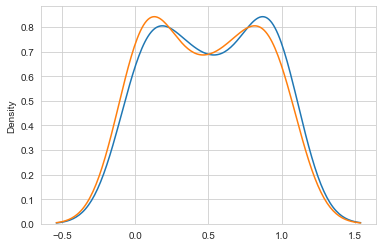

In [77]:
plot_kde(y_pred_df_finish)

Only user with >180 interactions

/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


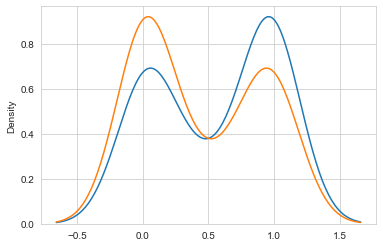

In [78]:
y_pred_over180 = y_pred_df_finish[y_pred_df_finish.n_interactions > threshold]
plot_kde(y_pred_over180)

/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/mauromarini/PycharmProjects/privacy_and_fairness_in_recsys/venv/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


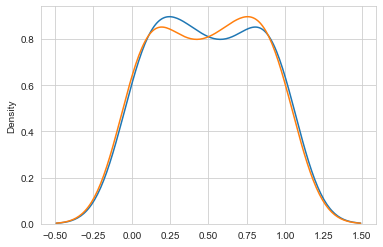

In [79]:
y_pred_less_eq180 = y_pred_df_finish[y_pred_df_finish.n_interactions <= threshold]
plot_kde(y_pred_less_eq180)